# Описание проекта: Анализ покупательской активности

## Цель исследования
Разработать модель машинного обучения, которая поможет бизнесу анализировать покупательскую активность клиентов на основе их поведения на сайте и выручки. Основная задача заключается в создании модели для предсказания активности клиентов:

1. Модель будет прогнозировать, снизится ли покупательская активность клиента (целевой признак: **Покупательская активность**).

Бизнес намерен отбирать клиентов по критериям, связанным с их активностью и выручкой.

## План исследования
1. **Изучение общей информации о данных**:
   - Анализ структуры и типов данных, выявление пропусков и дубликатов в наборах данных о клиентах и их покупках.

2. **Предобработка данных**:
   - Изменение названий столбцов для улучшения читаемости.
   - Преобразование типов данных (например, замена запятых на точки в числовых значениях).
   - Устранение явных и неявных дубликатов.
   - Обработка аномалий, таких как выбросы в значениях выручки.

3. **Исследовательский анализ данных (EDA)**:
   - Визуализация распределений количественных и категориальных переменных.
   - Выявление ключевых факторов, влияющих на покупательскую активность.
   - Корреляционный анализ для определения взаимосвязей между переменными.

4. **Моделирование**:
   - Построение модели классификации для предсказания покупательской активности клиентов.
   - Оценка качества модели с использованием метрик точности, полноты и F1-меры.

5. **Прогнозирование**:
   - Применение модели для прогнозирования активности клиентов на новых данных, что позволит бизнесу более эффективно планировать маркетинговые стратегии.

6. **Рекомендации**:
   - Предложение бизнесу проводить регулярный анализ данных для выявления изменений в покупательской активности.
   - Рекомендации по улучшению взаимодействия с клиентами на основе анализа их поведения и предпочтений.

## Ключевые данные и результаты
- В наборе данных содержится информация о клиентских транзакциях, включая такие параметры, как:
  - Количество покупок за определённый период.
  - Общая выручка от покупок.
  - Частота посещения сайта.
  - Данные о взаимодействии с рекламными акциями и скидками.
  - Демографические характеристики клиентов (возраст, пол, география).

- Результаты анализа могут показать:
  - Основные факторы, влияющие на покупательскую активность (например, влияние акций на объем продаж).
  - Модели поведения клиентов, которые помогают выделить группы с высокой вероятностью снижения активности.
  - Потенциальные сегменты клиентов, которые требуют дополнительного внимания для повышения их лояльности и активности.
  
- В конечном итоге, результаты исследования помогут бизнесу принимать более обоснованные решения для оптимизации маркетинговых стратегий и повышения общей выручки.


In [2]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from scipy import stats
from scipy.stats import spearmanr

from phik import phik_matrix

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             mean_absolute_error, mean_squared_error,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler,
                                   OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import shap

# Настроим широкоформатный Jupyter, максимальный вывод колонок
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Загрузка данных

In [3]:
try:
    df_market_file = pd.read_csv(r"C:\Users\nikita.rusanov\Documents\учеба\Один клик\market_file.csv" )
    df_market_money = pd.read_csv(r"C:\Users\nikita.rusanov\Documents\учеба\Один клик\market_money.csv" )
    df_market_time = pd.read_csv(r"C:\Users\nikita.rusanov\Documents\учеба\Один клик\market_time.csv" )
    df_money = pd.read_csv(r"C:\Users\nikita.rusanov\Documents\учеба\Один клик\money.csv", sep=';',decimal = ',' )
except:
    df_market_file = pd.read_csv('/datasets/market_file.csv')
    df_market_money = pd.read_csv('/datasets/market_money.csv')
    df_market_time = pd.read_csv('/datasets/market_time.csv')
    df_money = pd.read_csv('/datasets/money.csv', sep=';',decimal = ',' )

#### Функция `know` - знакомство с данными

In [4]:
def know(df):
    display(df.head())
    print('_'*100)
    print('Общая информация')
    df.info()
    print('_'*100)
    print('Характеристики распределения')
    display(df.describe().T)
    try:
        display(df.describe(include = ['object']).T)
    except:
        print('Нет столбцов типа object')
    print('_'*100)
    print('Кол-во дубликатов записей:', df.duplicated().sum())
    count = 0
    print('_'*100)
    print('Признаки типа object:')
    for column in df.select_dtypes(include=['object']).columns:
        print('\n', column, ': ', df[column].nunique(), 'категории - ', df[column].unique())
    print('_'*100)
    print('Пропуски в колонках:\n')
    for column in df.columns:
        if df[column].isna().sum() > 0:
            print(column, ' - ', df[column].isna().sum(), 'пропусков, ', round(df[column].isna().sum() * 100 / df.shape[0],2), '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков нет')

In [5]:
know(df_market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


____________________________________________________________________________________________________
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 no

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


,count,unique,top,freq
Покупательская активность,1300,2,Прежний уровень,802
Тип сервиса,1300,3,стандарт,914
Разрешить сообщать,1300,2,да,962
Популярная_категория,1300,6,Товары для детей,330


____________________________________________________________________________________________________
Кол-во дубликатов записей: 0
____________________________________________________________________________________________________
Признаки типа object:

 Покупательская активность :  2 категории -  ['Снизилась' 'Прежний уровень']

 Тип сервиса :  3 категории -  ['премиум' 'стандартт' 'стандарт']

 Разрешить сообщать :  2 категории -  ['да' 'нет']

 Популярная_категория :  6 категории -  ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
____________________________________________________________________________________________________
Пропуски в колонках:

Пропусков нет


In [6]:
know(df_market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


____________________________________________________________________________________________________
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
____________________________________________________________________________________________________
Характеристики распределения


,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


,count,unique,top,freq
Период,3900,3,текущий_месяц,1300


____________________________________________________________________________________________________
Кол-во дубликатов записей: 0
____________________________________________________________________________________________________
Признаки типа object:

 Период :  3 категории -  ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
____________________________________________________________________________________________________
Пропуски в колонках:

Пропусков нет


In [7]:
know(df_market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


____________________________________________________________________________________________________
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
____________________________________________________________________________________________________
Характеристики распределения


,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


,count,unique,top,freq
Период,2600,2,текущий_месяц,1300


____________________________________________________________________________________________________
Кол-во дубликатов записей: 0
____________________________________________________________________________________________________
Признаки типа object:

 Период :  2 категории -  ['текущий_месяц' 'предыдцщий_месяц']
____________________________________________________________________________________________________
Пропуски в колонках:

Пропусков нет


In [8]:
know(df_money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


____________________________________________________________________________________________________
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
____________________________________________________________________________________________________
Характеристики распределения


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


Нет столбцов типа object
____________________________________________________________________________________________________
Кол-во дубликатов записей: 0
____________________________________________________________________________________________________
Признаки типа object:
____________________________________________________________________________________________________
Пропуски в колонках:

Пропусков нет


# Промежуточные выводы

## 1. Общие характеристики данных:
- **df_market_file:**
  - Содержит 1300 записей и 13 столбцов.
  - В данных отсутствуют дубликаты.
  - Все столбцы заполнены, пропусков нет.
  - Имеются 4 столбца типа `object`, 2 столбца типа `float64` и 7 столбцов типа `int64`.

- **df_market_money:**
  - Содержит 3900 записей и 3 столбца.
  - Также нет дубликатов и пропусков.
  - Один столбец типа `object` и 2 столбца типа `float64` и `int64`.

- **df_market_time:**
  - Содержит 2600 записей и 3 столбца.
  - Нет дубликатов и пропусков.
  - Один столбец типа `object` и 2 столбца типа `int64`.

- **df_money:**
  - Содержит 1300 записей и 2 столбца.
  - Пропусков нет, дубликатов тоже нет.
  - Один столбец типа `object` и один столбец типа `int64`.

## 2. Статистические характеристики:
- В `df_market_file` средний показатель "Маркет_актив_6_мес" составляет 4.25, с минимальным значением 0.9 и максимальным 6.6.
- Для `df_market_money` средняя выручка составляет 5025.70, с минимальным значением 0.0 и максимальным 106862.20.
- В `df_market_time` среднее время составило 13.34 минут, с минимальным значением 4 и максимальным 23.
- В `df_money` данные о прибыли представлены в виде строк, что требует преобразования для дальнейшего анализа.

## 3. Категориальные переменные:
- В `df_market_file`:
  - "Покупательская активность" имеет 2 категории: "Снизилась" и "Прежний уровень".
  - "Тип сервиса" имеет 2 категории: "премиум" и "стандарт"".
  - "Разрешить сообщать" имеет 2 категории: "да" и "нет".
  - "Популярная категория" имеет 6 уникальных значений, среди которых "Товары для детей" наиболее частая.

- В `df_market_money`:
  - "Период" имеет 3 категории: "препредыдущий_месяц", "текущий_месяц" и "предыдущий_месяц".

- В `df_market_time`:
  - "Период" имеет 2 категории: "текущий_месяц" и "предыдущий_месяц".



In [9]:
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


##  Предобработка данных

**Измененим названия столбцов**

In [10]:
def remove(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [11]:
remove(df_market_file)
remove(df_market_money)
remove(df_market_time)
remove(df_money)

In [12]:
print('Названия столбцов в df_market_file')
display(df_market_file.columns)
print('---------------------------------------------------------------------------')

print('Названия столбцов в df_market_money')
display(df_market_money.columns)
print('---------------------------------------------------------------------------')

print('Названия столбцов в df_market_time')
display(df_market_time.columns)
print('---------------------------------------------------------------------------')

print('Названия столбцов в df_money')
display(df_money.columns)

Названия столбцов в df_market_file


Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

---------------------------------------------------------------------------
Названия столбцов в df_market_money


Index(['id', 'период', 'выручка'], dtype='object')

---------------------------------------------------------------------------
Названия столбцов в df_market_time


Index(['id', 'период', 'минут'], dtype='object')

---------------------------------------------------------------------------
Названия столбцов в df_money


Index(['id', 'прибыль'], dtype='object')

Заменяем в df_market_file значение 'стандартт' на 'стандарт' и в df_market_time значение 'предыдцщий_месяц' на 'предыдущий_месяц'

In [13]:
df_market_file['тип_сервиса'] = df_market_file['тип_сервиса'].replace('стандартт', 'стандарт')
df_market_time['период'] = df_market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [14]:
df_market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [15]:
df_market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Проверим наличие аномалий**

In [16]:
display(df_market_file.describe())
print('----------------------------------------------------------------------------------------') 
display(df_market_money.describe())
print('----------------------------------------------------------------------------------------')  
display(df_market_time.describe())
print('----------------------------------------------------------------------------------------')  
display(df_money.describe())

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


----------------------------------------------------------------------------------------


,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


----------------------------------------------------------------------------------------


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


----------------------------------------------------------------------------------------


,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Обнаружено аномальное значение df_market_money['выручка']

In [17]:
df_market_money.sort_values('выручка')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
...,...,...,...
2388,216144,текущий_месяц,7547.8
1481,215841,текущий_месяц,7557.0
262,215435,текущий_месяц,7605.3
435,215493,текущий_месяц,7799.4


Удалим запись с выручкой 106862,2

In [18]:
df_market_money = df_market_money[df_market_money['выручка']!=106862.2]

## Вывод

На данном этапе исследования были проделаны следующие шаги:

1. **Переименовывание колонок**. В данном проекте позволяется использование кириллических названий колонок, поэтому были произведены замены пробелов на символ подчеркивания, чтобы обеспечить корректное обращение к столбцам.

2. **Приведение типов**. Обнаружено, что колонка "Прибыль" в `df_money`, содержащие численные значения, были отмечены как нечисловые типы данных. Исправили это, теперь все типы данных соответствуют содержимому столбцов. 

3. **Обработка дублей**. Явных дублей данных не обнаружено.

4. **Обработка пропусков**. В ходе анализа категориальных признаков не было выявлено явных и неявных пропусков. Все колонки заполнены, и на текущий момент количество пропусков равно нулю. Количественные признаки будут исследованы на следующем этапе исследования для выявления возможных пропусков или аномалий в данных.

5. **Обнаружение аномалий**. В процессе анализа данных была выявлена аномалия в столбце выручка из таблицы df_market_money. Данное значение удалили


## Исследовательский анализ данных

**Создадим функции для визуализации количественных и категориальных переменных**

In [19]:
# Функция для визуализации количественных переменных
def plot_numerical_distribution(dataframe, variable, title):
    sns.set(style="whitegrid")
    #sns.set(style="ticks")
    plt.figure(figsize=(15, 6))

    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(dataframe[variable], bins=20, kde=True, color='skyblue')
    plt.title(f'Гистограмма: {title}', fontsize=16)
    plt.xlabel(variable, fontsize=14)
    plt.ylabel('Количество', fontsize=14)
    plt.grid(axis='y')

    # Боксплот
    plt.subplot(1, 2, 2)
    sns.boxplot(y=dataframe[variable], color='lightgreen')
    plt.title(f'Боксплот: {title}', fontsize=16)
    plt.ylabel(variable, fontsize=14)
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

# Функция для визуализации категориальных переменных
def plot_categorical_distribution(dataframe, variable, title):
    plt.figure(figsize=(12, 6))
    
    # Получаем количество каждой категории и сортируем по убыванию
    category_counts = dataframe[variable].value_counts()
    sorted_categories = category_counts.index

    # Столбчатая диаграмма с долями
    ax = sns.countplot(data=dataframe, x=variable, order=sorted_categories, palette='pastel')
    plt.title(f'Распределение: {title}', fontsize=18)
    plt.xlabel(variable, fontsize=14)
    plt.ylabel('Количество', fontsize=14)
    plt.xticks(rotation=45)

    # Добавление аннотаций на график
    total = len(dataframe[variable])
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total * 100
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., count), 
                    ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


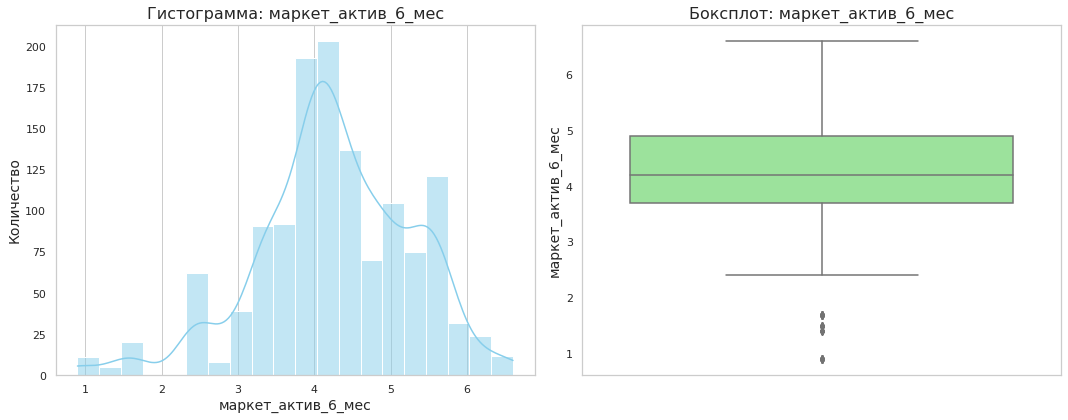

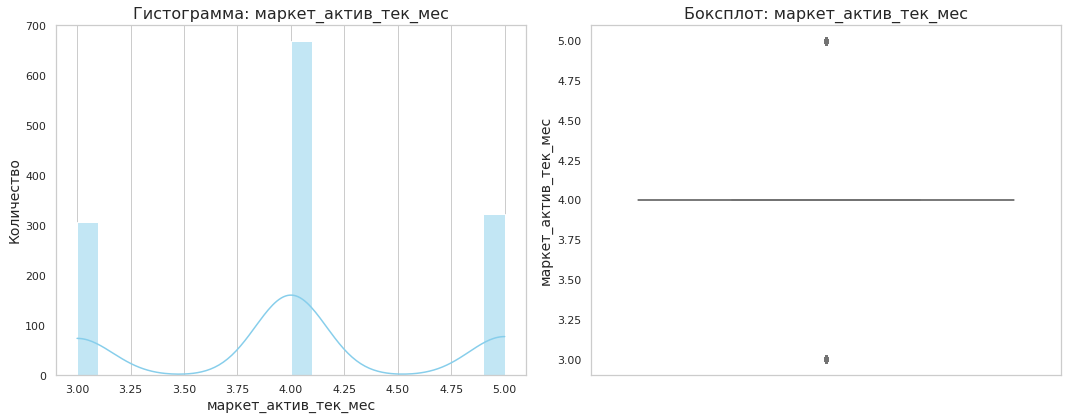

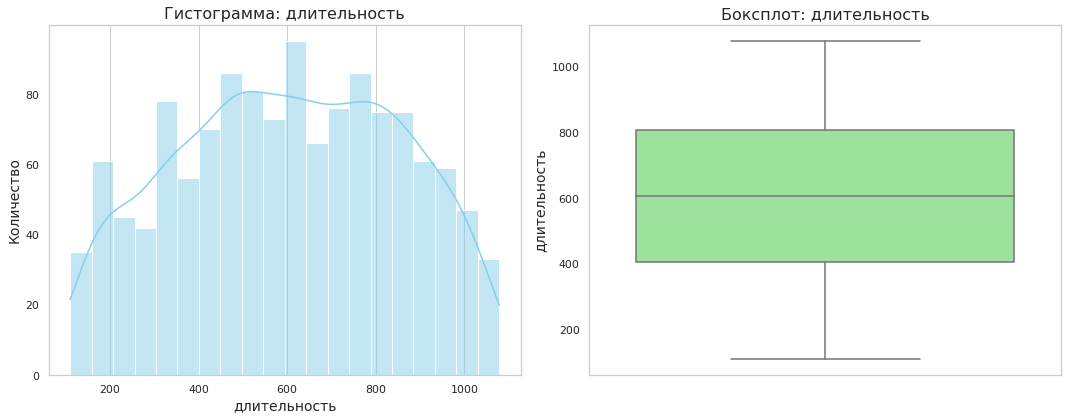

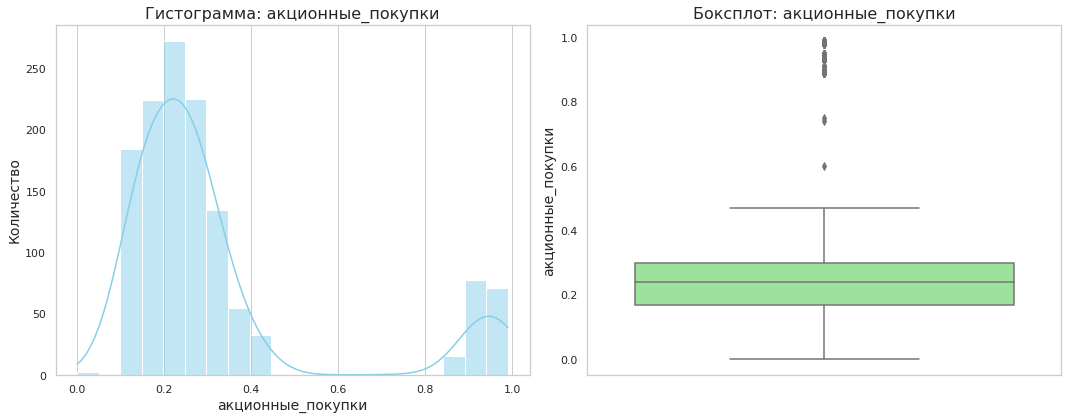

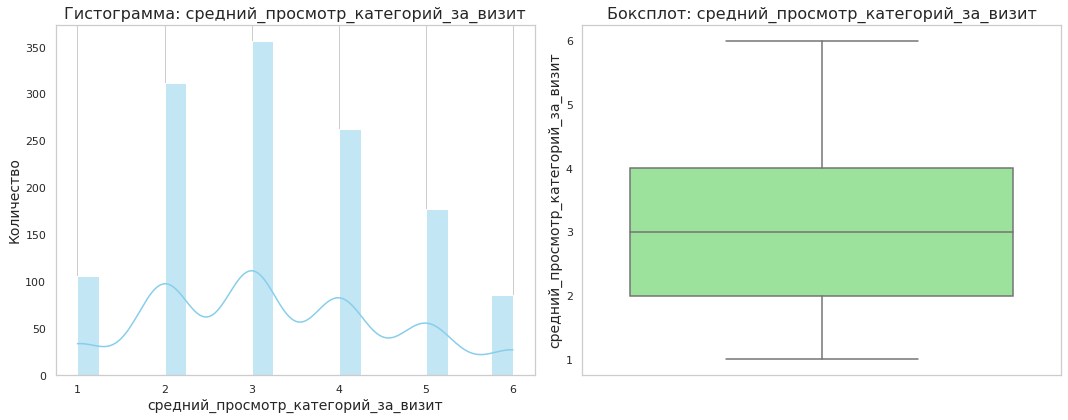

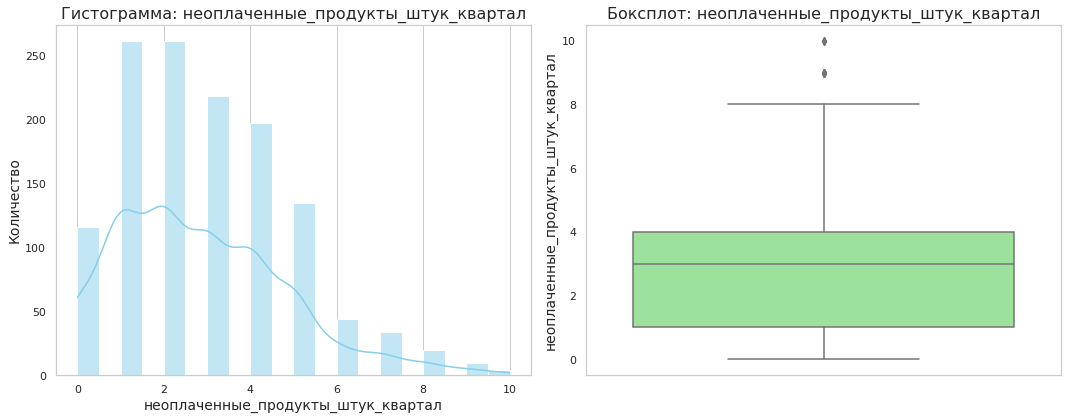

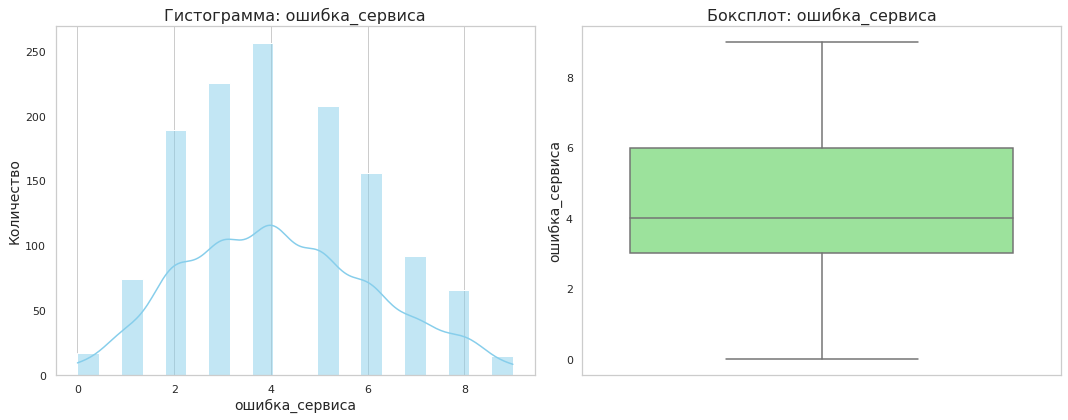

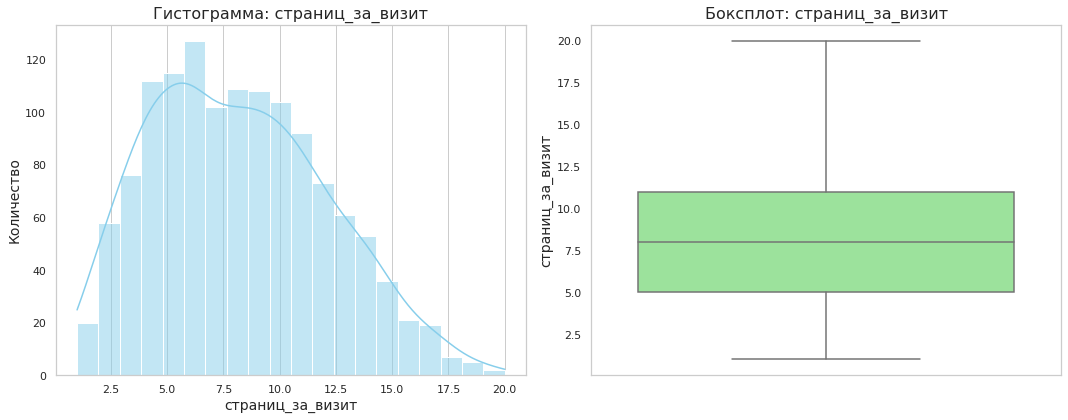

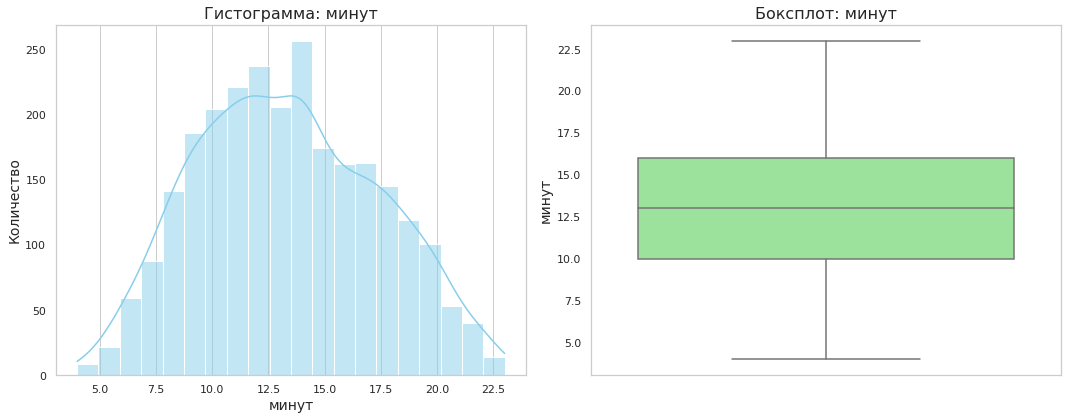

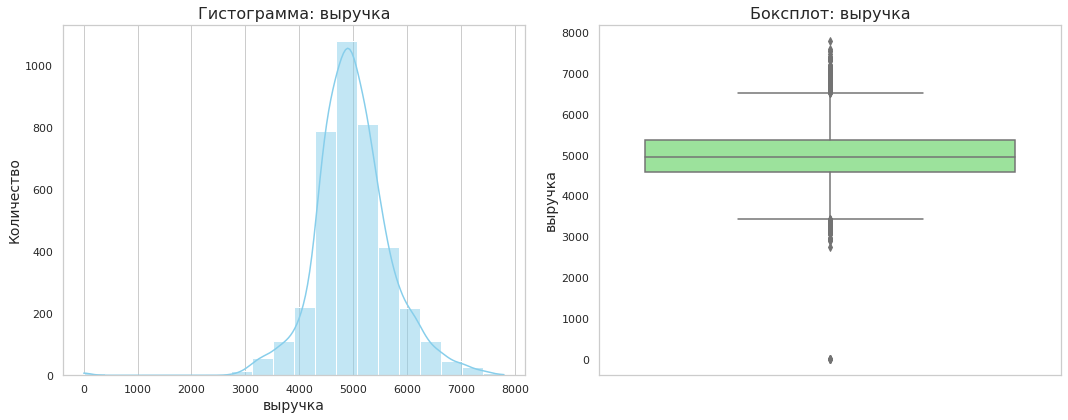

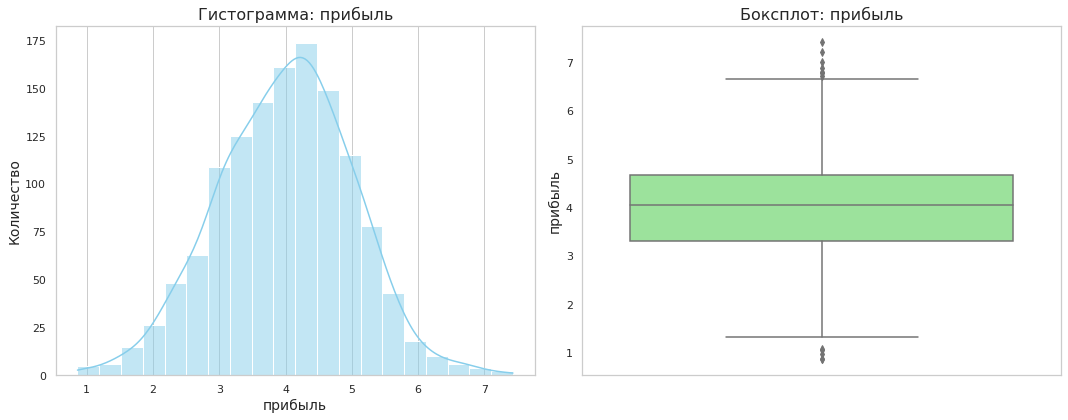

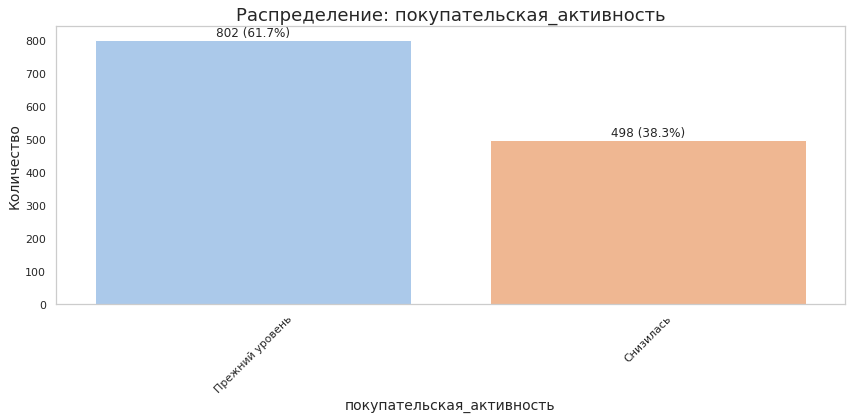

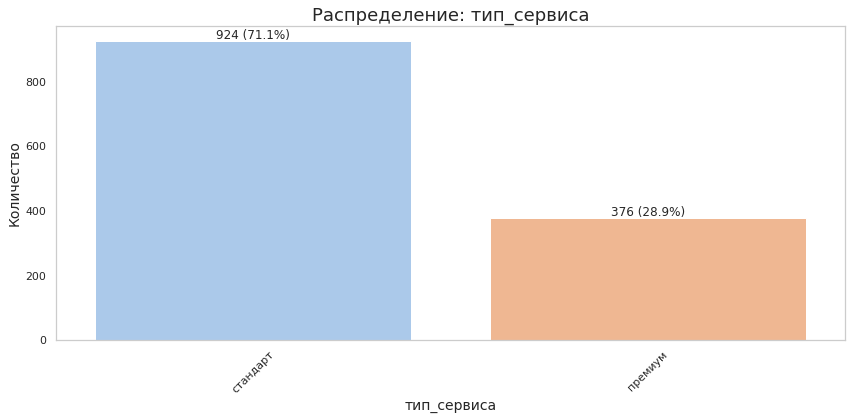

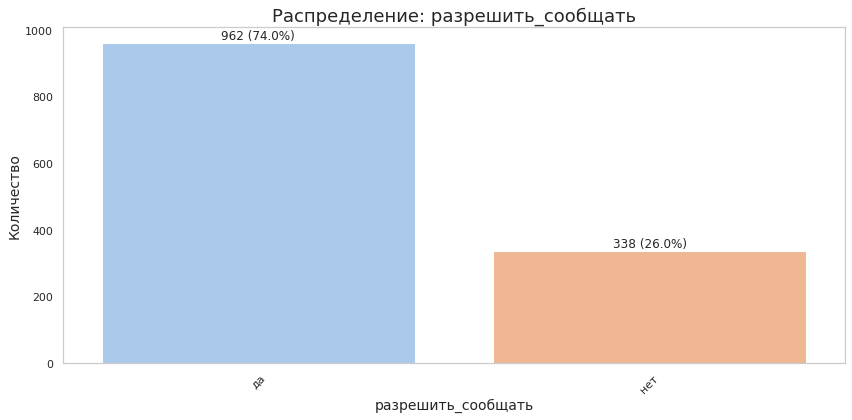

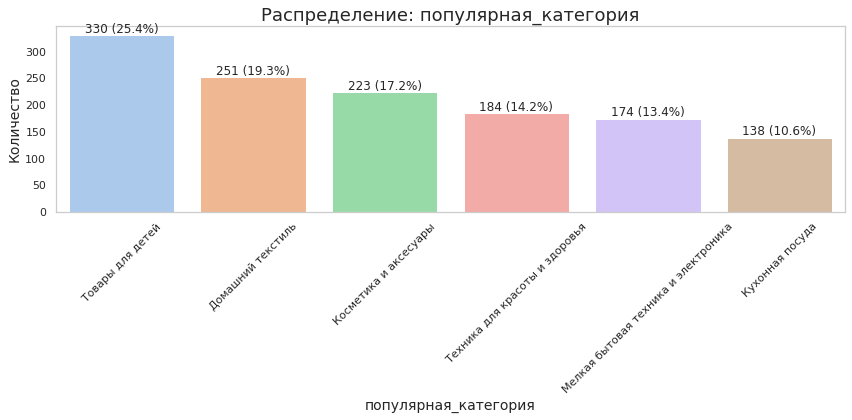

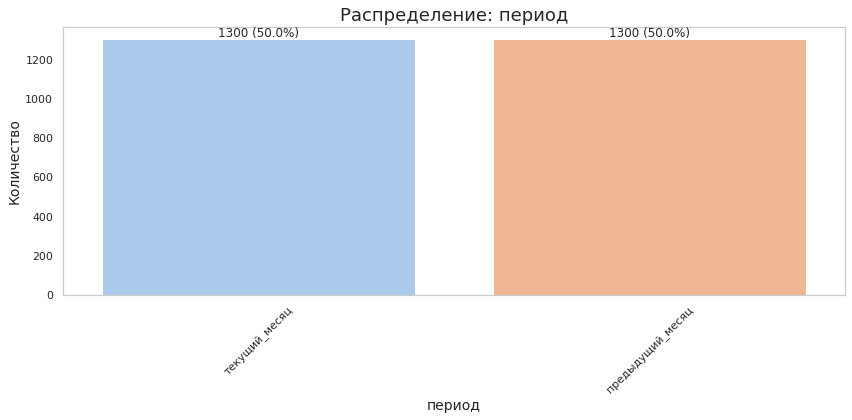

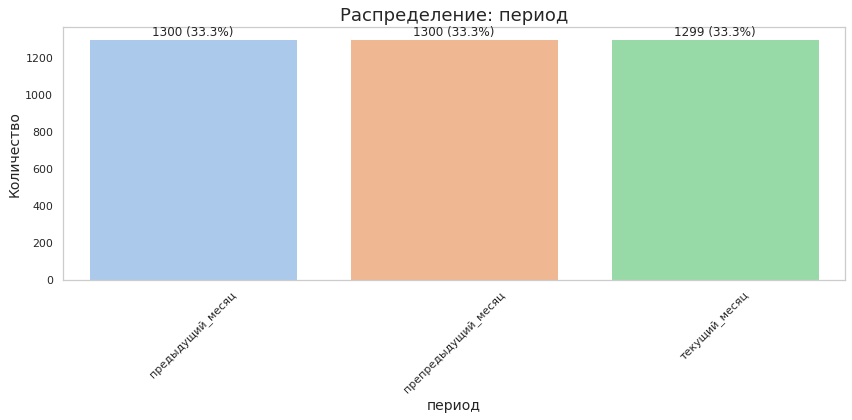

In [20]:
# Визуализация количественных переменных
quantitative_vars = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
]

# Визуализируем переменные из df_market_file
for var in quantitative_vars:
    plot_numerical_distribution(df_market_file, var, var)

# Визуализация переменных из df_market_time
plot_numerical_distribution(df_market_time, 'минут', 'минут')

# Визуализация переменных из df_market_money
plot_numerical_distribution(df_market_money, 'выручка', 'выручка')

# Визуализация переменной 'прибыль' из df_money
# Сначала нужно преобразовать 'прибыль' в числовой формат, если это необходимо
#df_money['прибыль'] = pd.to_numeric(df_money['прибыль'], errors='coerce')  # Преобразование в числовой формат
plot_numerical_distribution(df_money, 'прибыль', 'прибыль')

# Визуализация категориальных переменных
categorical_vars = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
]

for var in categorical_vars:
    plot_categorical_distribution(df_market_file, var, var)

# Визуализация переменной 'период' из df_market_time и df_market_money
plot_categorical_distribution(df_market_time, 'период', 'период')
plot_categorical_distribution(df_market_money, 'период', 'период')

### Вывод по количественным и категориальным признакам

### Количественные признаки

1. **Признак `актив_6_мес`**
   - Распределение: Нормальное
   - Замечание: Есть несколько слишком малых значений. Возможно, потребуется их удалить.

2. **Признак `актив_тек_мес`**
   - Признак можно сделать категориальным с 3 категориями.

3. **Признак `длительность`**
   - Распределение: Равномерное на всем диапазоне значений.

4. **Признак `акции`**
   - Распределение: Бимодальное (в области 0,2 и близкой к 1).
   - Замечание: Значительная доля покупателей, которые покупают только по акции.

5. **Признак `категорий_за_визит`**
   - Распределение: Нормальное.

6. **Признак `неоплачено_штук`**
   - Распределение: Слегка скошенное влево.

7. **Признак `ошибки`**
   - Распределение: Нормальное.

8. **Признак `страницы`**
   - Распределение: Слегка скошенное влево нормальное распределение.

9. **Признак `выручка`**
   - Распределение: Нормальное.
   - Замечание: Имеются нулевые значения (пользователи, не совершавшие покупки).

10. **Признак `прибыль`**
    - Распределение: Нормальное.

### Категориальные признаки

- Признаки `['активность', 'сервис', 'рассылка', 'категория']` имеют несбалансированное распределение.
  
- Признак `период` распределен равномерно.


Объединим таблицы df_market_file и df_market_money, чтобы получить полную информацию о клиентах и их выручке.

In [21]:
df_market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [22]:
df_market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [23]:
# Разворачиваем таблицу df_market_money
pivoted_money = df_market_money.pivot_table(index='id', columns='период', values='выручка').reset_index()

# Переименовываем столбцы для удобства
pivoted_money.columns.name = None  # Убираем имя индекса
pivoted_money.columns = ['id', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц']
pivoted_money = pivoted_money[['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']]

# Отбираем клиентов с активностью не менее трех месяцев
filtered_data = pivoted_money[
    (pivoted_money['выручка_препредыдущий_месяц'] > 0) &
    (pivoted_money['выручка_предыдущий_месяц'] > 0) &
    (pivoted_money['выручка_текущий_месяц'] > 0)
]
# Получаем информацию о клиентах
active_clients_info = filtered_data.merge(df_market_file, on='id', how='left')
# Выводим информацию о клиентах
print(f"Количество клиентов с покупательской активностью не менее трёх месяцев: {active_clients_info.shape[0]}")
display(active_clients_info.head())

Количество клиентов с покупательской активностью не менее трёх месяцев: 1296


,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215349,5216.0,4971.6,4472.0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,5457.5,5058.4,4826.0,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,6158.0,6610.4,4793.0,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,5807.5,5872.5,4594.0,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,4738.5,5388.5,5124.0,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


### Выводы по результатам шага

1. **Количество активных клиентов**: Мы отобрали клиентов, которые имели положительную выручку в трех и более месяцах. Это позволяет нам сосредоточиться на наиболее активных клиентах, что может быть полезно для дальнейшего анализа или маркетинговых стратегий.

2. **Данные о клиентах**: Мы можем проанализировать характеристики этих клиентов, такие как их тип сервиса, популярные категории товаров, а также статистику по покупательской активности. Это может помочь в выявлении моделей поведения и предпочтений среди наиболее активных клиентов.

3. **Маркетинговые стратегии**: Зная, какие клиенты являются наиболее активными, можно разработать более целенаправленные маркетинговые стратегии, такие как специальные предложения или акции, чтобы увеличить их лояльность и частоту покупок.

4. **Дальнейший анализ**: Мы можем провести дальнейший анализ, чтобы выяснить, какие факторы влияют на активность клиентов, и как мы можем улучшить взаимодействие с ними для увеличения выручки.


## Объединение таблиц

In [24]:
# Разворачиваем таблицу df_market_money
pivoted_time = df_market_time.pivot_table(index='id', columns='период', values='минут').reset_index()
pivoted_money.columns.name = None  # Убираем имя индекса
pivoted_time.columns = ['id', 'минут_препредыдущий_месяц', 'минут_текущий_месяц']

In [25]:
# Объединяем данные
df = active_clients_info.merge(pivoted_time, on='id', how='left')

# Проверим результат объединения
know(df)

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_препредыдущий_месяц,минут_текущий_месяц
0,215349,5216.0,4971.6,4472.0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,215350,5457.5,5058.4,4826.0,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,215351,6158.0,6610.4,4793.0,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,215352,5807.5,5872.5,4594.0,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,215353,4738.5,5388.5,5124.0,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


____________________________________________________________________________________________________
Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   выручка_препредыдущий_месяц          1296 non-null   float64
 2   выручка_предыдущий_месяц             1296 non-null   float64
 3   выручка_текущий_месяц                1296 non-null   float64
 4   покупательская_активность            1296 non-null   object 
 5   тип_сервиса                          1296 non-null   object 
 6   разрешить_сообщать                   1296 non-null   object 
 7   маркет_актив_6_мес                   1296 non-null   float64
 8   маркет_актив_тек_мес                 1296 non-null   int64  
 9   длительность                         1296 no

,count,mean,std,min,25%,50%,75%,max
id,1296.0,215999.464506,374.327860,215349.00,215675.750,215999.50,216323.250,216647.00
выручка_препредыдущий_месяц,1296.0,4947.468750,700.797239,2890.00,4498.125,5005.50,5405.625,6869.50
выручка_предыдущий_месяц,1296.0,5238.096065,834.318717,2758.70,4706.050,5179.95,5759.275,7799.40
выручка_текущий_месяц,1296.0,4836.202160,333.514091,4098.00,4584.500,4810.50,5056.000,5663.00
маркет_актив_6_мес,1296.0,4.256404,1.013525,0.90,3.700,4.20,4.900,6.60
маркет_актив_тек_мес,1296.0,4.009259,0.696316,3.00,4.000,4.00,4.000,5.00
длительность,1296.0,602.967593,249.195823,121.00,409.500,606.50,806.250,1079.00
акционные_покупки,1296.0,0.320069,0.249159,0.11,0.170,0.24,0.300,0.99
средний_просмотр_категорий_за_визит,1296.0,3.267747,1.355125,1.00,2.000,3.00,4.000,6.00
неоплаченные_продукты_штук_квартал,1296.0,2.841821,1.974074,0.00,1.000,3.00,4.000,10.00


,count,unique,top,freq
покупательская_активность,1296,2,Прежний уровень,802
тип_сервиса,1296,2,стандарт,922
разрешить_сообщать,1296,2,да,959
популярная_категория,1296,6,Товары для детей,329


____________________________________________________________________________________________________
Кол-во дубликатов записей: 0
____________________________________________________________________________________________________
Признаки типа object:

 покупательская_активность :  2 категории -  ['Снизилась' 'Прежний уровень']

 тип_сервиса :  2 категории -  ['премиум' 'стандарт']

 разрешить_сообщать :  2 категории -  ['да' 'нет']

 популярная_категория :  6 категории -  ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Кухонная посуда' 'Техника для красоты и здоровья'
 'Мелкая бытовая техника и электроника']
____________________________________________________________________________________________________
Пропуски в колонках:

Пропусков нет


## Корреляционный анализ

In [26]:
df.head()

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_препредыдущий_месяц,минут_текущий_месяц
0,215349,5216.0,4971.6,4472.0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
1,215350,5457.5,5058.4,4826.0,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
2,215351,6158.0,6610.4,4793.0,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
3,215352,5807.5,5872.5,4594.0,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
4,215353,4738.5,5388.5,5124.0,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10


**Функций для построения матрицы корреляции**

In [27]:
def plot_correlation_matrix(correlation_matrix, x_labels, y_labels, vmin, vmax, color_map, title, fontsize_factor, figsize):
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=color_map, vmin=vmin, vmax=vmax, 
                xticklabels=x_labels, yticklabels=y_labels, square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 8})
    plt.title(title, fontsize=fontsize_factor * 10)
    plt.show()

Определяем количественные признаки

In [28]:
interval_cols = df.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

**Корреляционный анализ для категории "Снизилась"**

Удалим из таблицы некоррелирующие признаки

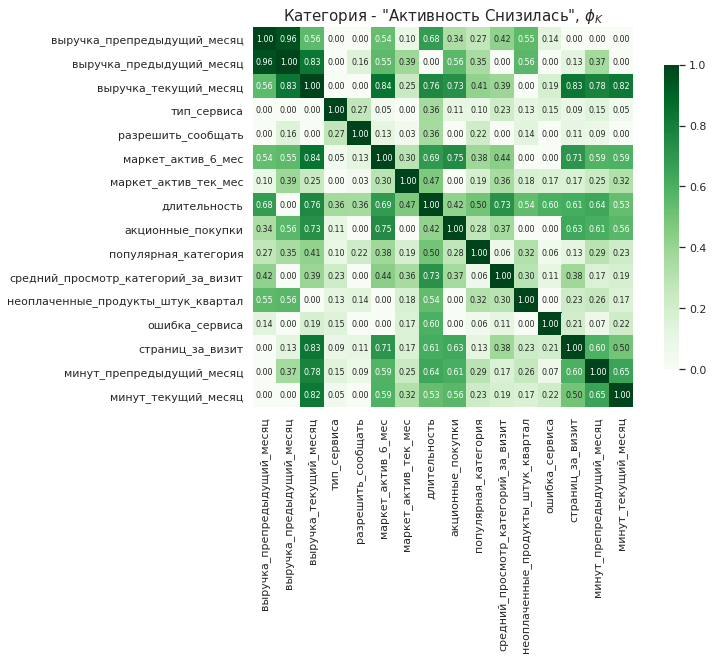

In [29]:
phik_overview_1category = phik_matrix(df[df['покупательская_активность'] == 'Снизилась'].drop(['id', 'покупательская_активность'], axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_overview_1category.values,
    x_labels=phik_overview_1category.columns,
    y_labels=phik_overview_1category.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Категория - "Активность Снизилась", $\phi_K$',
    fontsize_factor=1.5,
    figsize=(11, 7)
)


**Корреляционный анализ для категории "Прежний уровень"**

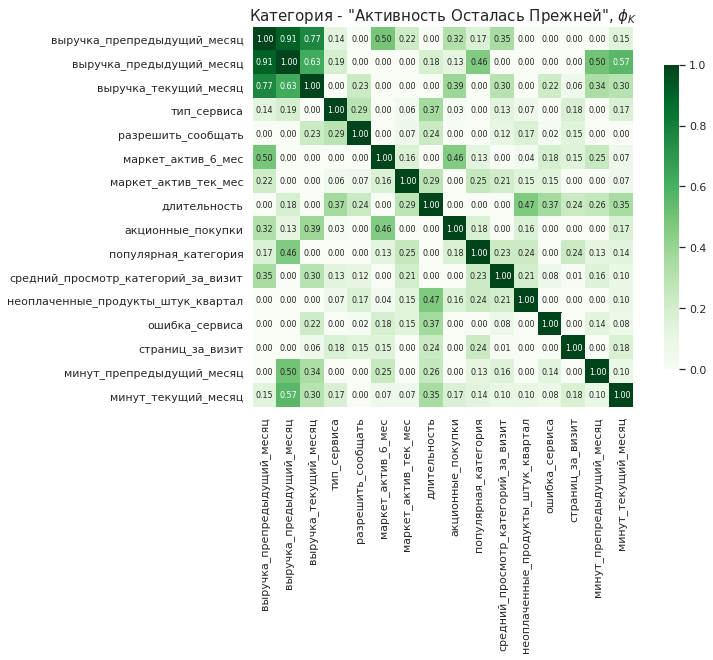

In [30]:
phik_overview_2category = phik_matrix(df[df['покупательская_активность'] == 'Прежний уровень'].drop(['id', 'покупательская_активность'], axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_overview_2category.values,
    x_labels=phik_overview_2category.columns,
    y_labels=phik_overview_2category.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Категория - "Активность Осталась Прежней", $\phi_K$',
    fontsize_factor=1.5,
    figsize=(11, 7)
)


**Функция для построения матрицы диаграмм рассеяния**

In [31]:
def plot_scatter_matrix(dataframe, title, figsize):
    axes = pd.plotting.scatter_matrix(dataframe, figsize=figsize, color='blue')
    
    for ax in axes.flatten():
        ax.xaxis.label.set_rotation(45)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')

    plt.suptitle(title, fontsize=24, fontweight="bold", color='blue')
    plt.show()

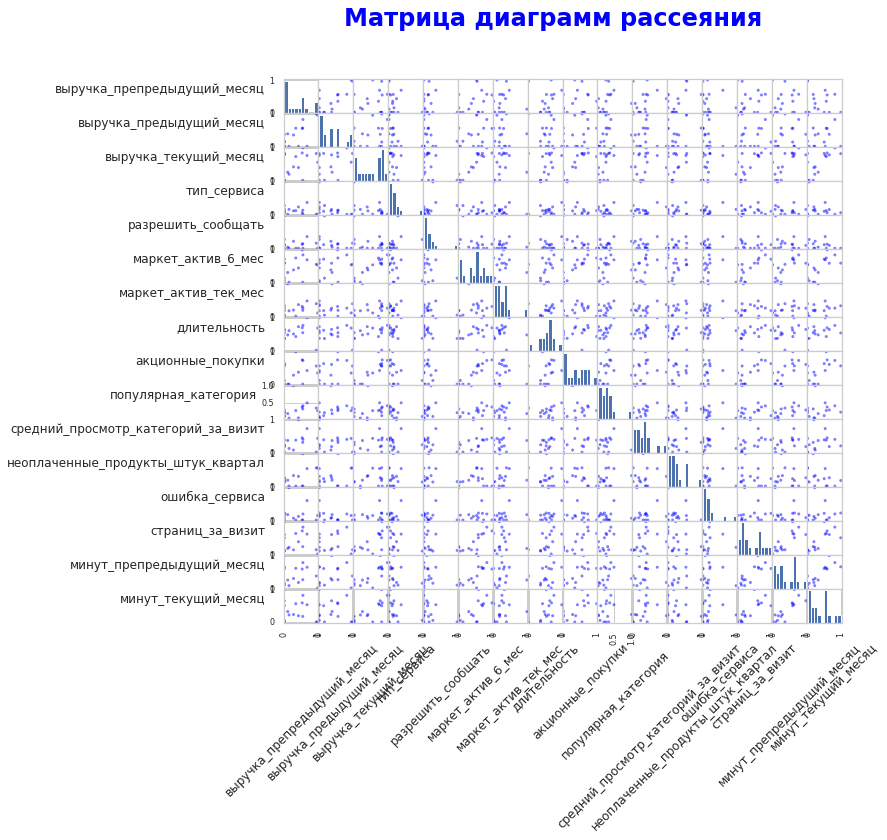

In [32]:
plot_scatter_matrix(
    dataframe=phik_overview_1category,
    title='Матрица диаграмм рассеяния',
    figsize=(10, 10)
)

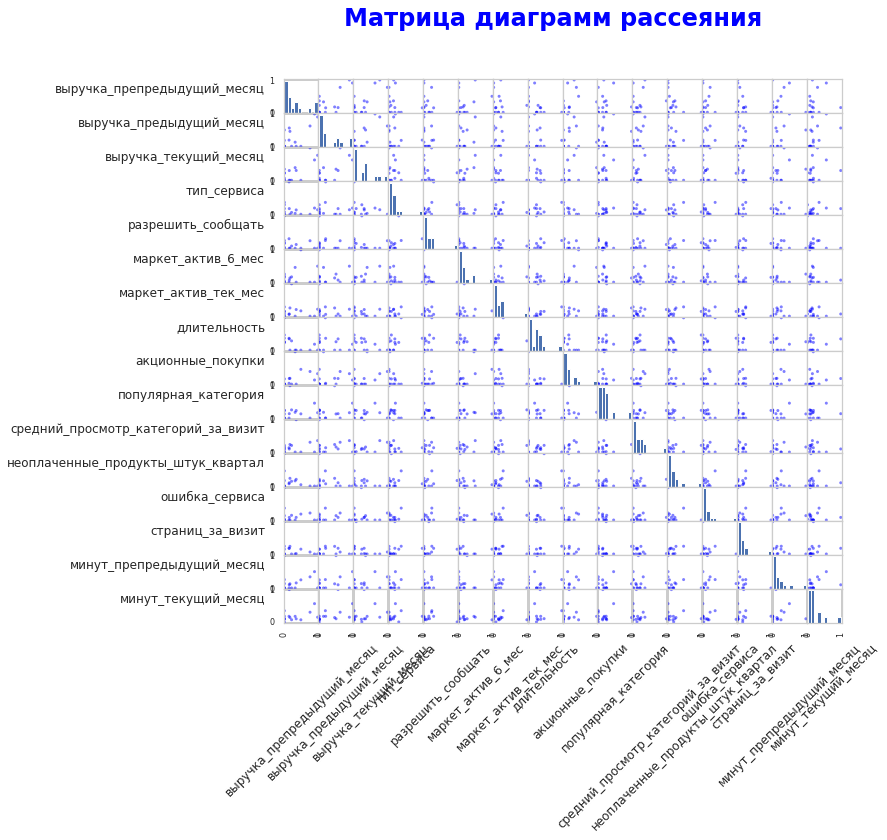

In [33]:
plot_scatter_matrix(
    dataframe=phik_overview_2category,
    title='Матрица диаграмм рассеяния',
    figsize=(10, 10)
)

**Вывод:**

Наблюдается высокая связь между признаками **Выручка_предыдущий_месяц** и **Выручка_текущий_месяц** с коэффициентом корреляции **0.8**. Ка

## Использование пайплайнов

Проверим баланс данных по целевому признаку:

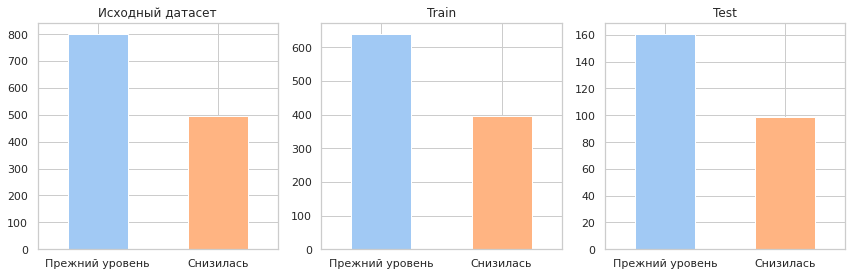

In [34]:
RANDOM_STATE=42

X = df.drop(['покупательская_активность', 'id'], axis=1)
y= df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

colors = sns.color_palette('pastel', n_colors=len(y.value_counts()))
y.value_counts().plot(kind='bar', ax=ax[0], rot=0, color=colors)
ax[0].set_title("Исходный датасет")
y_train.value_counts().plot(kind='bar', ax=ax[1], rot=0, color=colors)
ax[1].set_title("Train")
y_test.value_counts().plot(kind='bar', ax=ax[2], rot=0, color=colors)
ax[2].set_title("Test")

plt.tight_layout()
plt.show()

Для устранения дисбаланса целевого признака будем использовать стратифицированные выборки.

Разобьем данные на тренировочную и тестовую выборки:

In [35]:
X = df.drop(['id', 'покупательская_активность'], axis=1)
y = df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y 
)

Посмотрим на размерности полученных выборок:

In [36]:
print('Размерность выборки X_train: ', X_train.shape)
print('Размерность выборки X_test: ', X_test.shape)
print('Размерность выборки y_train: ', y_train.shape)
print('Размерность выборки y_test: ', y_test.shape)

Размерность выборки X_train:  (1036, 16)
Размерность выборки X_test:  (260, 16)
Размерность выборки y_train:  (1036,)
Размерность выборки y_test:  (260,)


Разобьем данные на количественные и категориальные:

In [37]:
#создание списков количественных и категориальных признаков
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']

#количественные
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 'выручка_препредыдущий_месяц', 
               'выручка_предыдущий_месяц', 'минут_препредыдущий_месяц', 
               'минут_текущий_месяц', 'маркет_актив_тек_мес', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']

# Кодирование целевой переменной


**Создадим пайплайн для OneHotEncoder**

In [39]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)) #sparse_output=False
])

**Создадим пайплайн для OedinalEncoder**

In [40]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(categories=[
        ['стандарт', 'премиум'], 
        ['да', 'нет']
    ], 
                             handle_unknown='use_encoded_value', unknown_value=np.nan)
    ),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
]
)

Создадим единый пайплайн по подготовке данны

In [41]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
], 
    remainder='passthrough'
)

Проверим работоспособность получившегося пайплайна

Определение моделей и их параметров

In [42]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            probability=True
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }    
    
]


In [43]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleIm...
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [44]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
        

In [45]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.91


Text(0.5, 12.5, 'Предсказания')

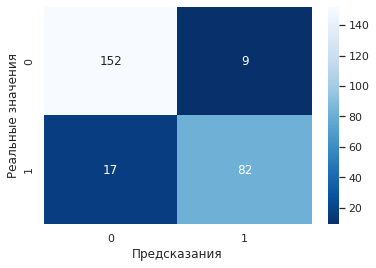

In [46]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальные значения')
plt.xlabel('Предсказания')

### Вывод

В ходе работы была проведена подготовка данных, созданы пайплайны для обработки категориальных и количественных признаков, что значительно упростило процесс предобработки. В результате применения `RandomizedSearchCV` была выбрана модель `LogisticRegression`, продемонстрировавшая метрику ROC-AUC 0.90 на тестовой выборке, что указывает на хорошую способность модели различать классы

# Анализ важности признаков

In [47]:
X = df.drop(['покупательская_активность', 'id'], axis=1)
y= df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [48]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

In [49]:
y_combined_pred = randomized_search.predict(X_combined)
predictions_df = pd.DataFrame(y_combined_pred, columns=["прогноз"])

In [50]:
y_combined_prob_class1 = randomized_search.predict_proba(X_combined)[:, 1]
prob_class1_df = pd.DataFrame(y_combined_prob_class1, columns=["вероятность_снижения"])

In [51]:
df['прогноз'] = predictions_df
df['вероятность_снижения'] = prob_class1_df
df.head()

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_препредыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения
0,215349,5216.0,4971.6,4472.0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,Прежний уровень,0.054227
1,215350,5457.5,5058.4,4826.0,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,Прежний уровень,0.037332
2,215351,6158.0,6610.4,4793.0,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,Прежний уровень,0.428902
3,215352,5807.5,5872.5,4594.0,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,Прежний уровень,0.391879
4,215353,4738.5,5388.5,5124.0,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,Снизилась,0.958603


In [52]:
# Используем лучший препроцессор из найденной модели
best_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

# Применяем препроцессор к тренировочным и тестовым данным
X_train_2 = best_preprocessor.fit_transform(X_train)
X_test_2 = best_preprocessor.transform(X_test)

In [54]:

# Получаем имена признаков
feature_names = best_preprocessor.get_feature_names_out()

# Преобразуем X_test_2 в DataFrame с правильными именами признаков
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

# Обучаем SHAP-объяснитель
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)
shap_values = explainer(X_test_2)

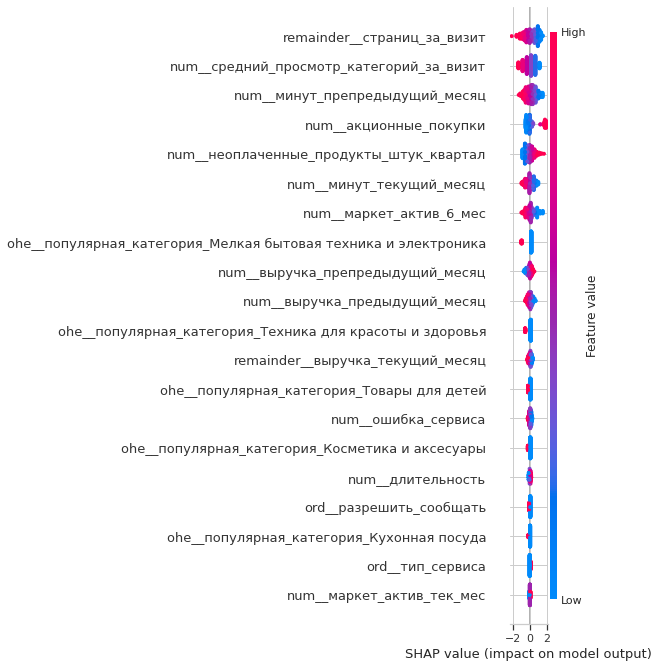

In [57]:
shap.summary_plot(shap_values, X_test_2, feature_names=feature_names)


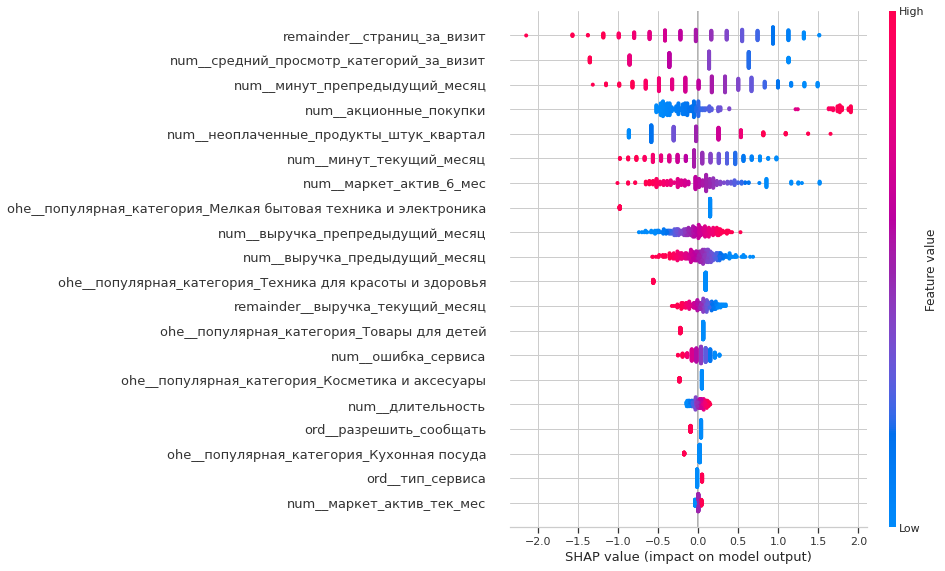

In [58]:
shap.plots.beeswarm(shap_values, max_display=20)

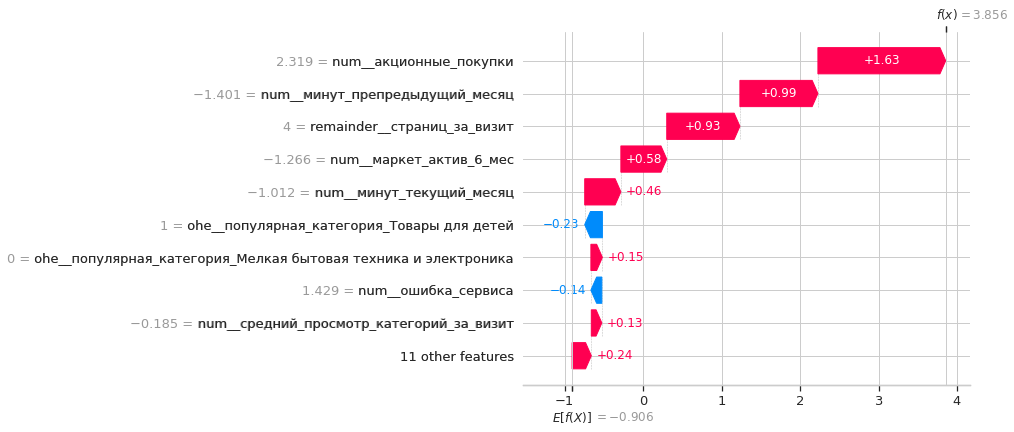

In [59]:
shap.plots.waterfall(shap_values[5])

# Признаки, связанные с активностью клиентов

## Признаки, больше всего связанные с активностью клиентов
- Число страниц за визит
- Времяпровождение в текущем и предыдущем месяцах
- Количество просмотренных категорий в среднем

## Признаки, меньше всего связанные с активностью клиентов
- Количество маркетинговых коммуникаций в текущем месяце
- Информация о том, можно ли присылать покупателю дополнительные предложения о товаре
- Уровень сервиса, например «премиум» и «стандарт»

## Активность пользователя снизится, если
- Среднее число просмотренных категорий за визит очень маленькое
- Маленькое количество просмотренных страниц за визит
- В целом небольшое времяпровождение на сайте
- Большое количество неоплаченных покупок
- Низкая выручка за позапрошлый месяц

# Сегментация покупателей

Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

In [61]:
data = df.merge(df_money, on='id', how='inner')

In [62]:
data.sample(n=1)

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_препредыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения,прибыль
651,216003,3903.0,3227.0,4833.0,Прежний уровень,премиум,да,5.5,5,913,0.25,Кухонная посуда,3,1,7,10,17,23,Прежний уровень,0.1803,4.87


In [63]:
def scatplt(data, x, y):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x, y=y, hue='тип_сервиса', palette='viridis', alpha=0.6)
    plt.title(f'Зависимость {y} от {x}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid()
    plt.legend(title='Тип сервиса')
    plt.show()



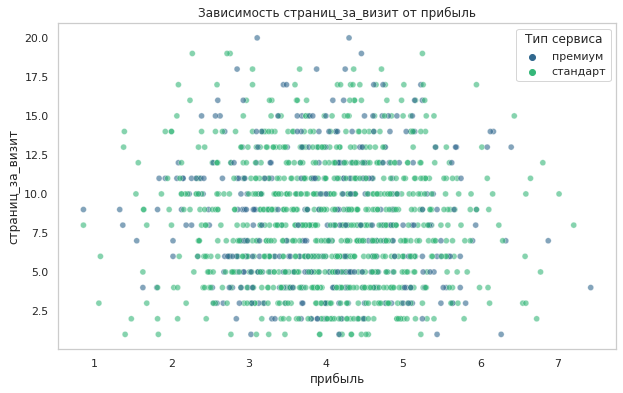

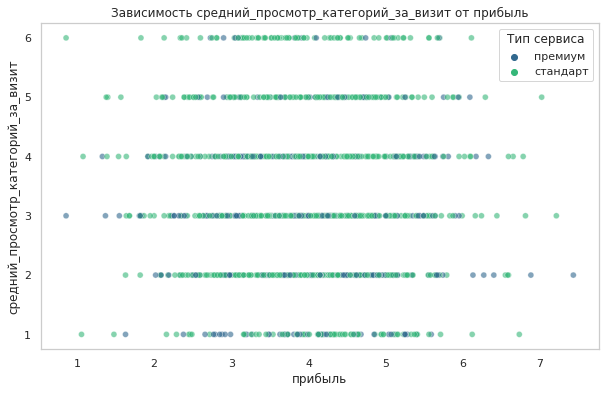

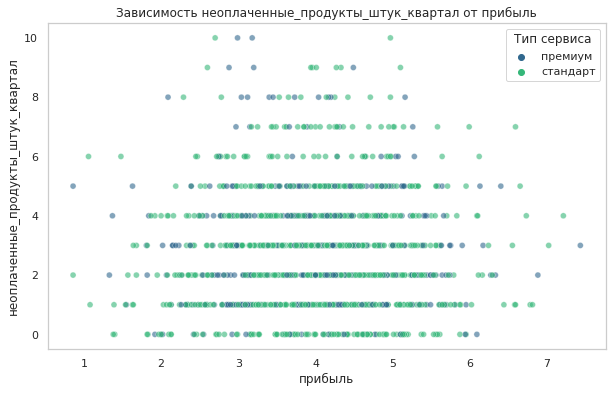

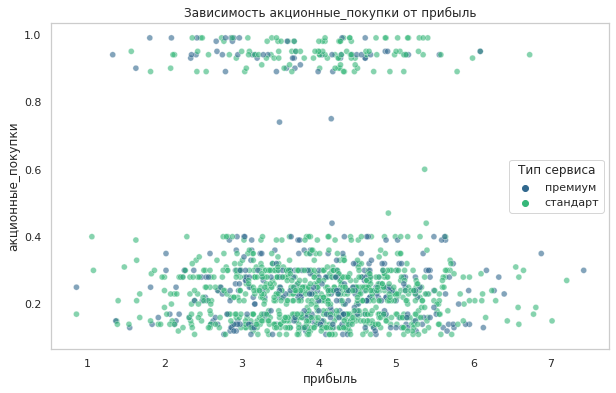

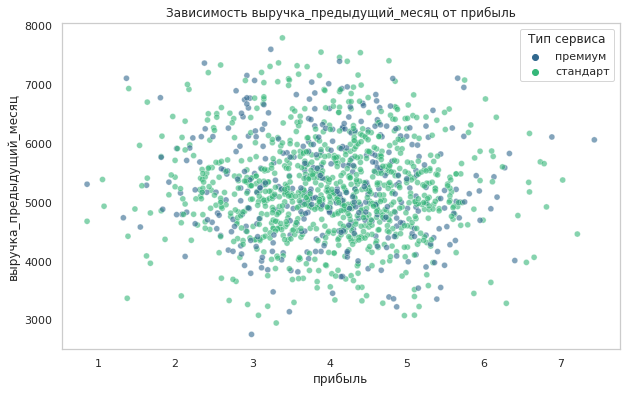

In [64]:
# Визуализация
scatplt(data, 'прибыль', 'страниц_за_визит')
scatplt(data, 'прибыль', 'средний_просмотр_категорий_за_визит')
scatplt(data, 'прибыль', 'неоплаченные_продукты_штук_квартал')
scatplt(data, 'прибыль', 'акционные_покупки')
scatplt(data, 'прибыль', 'выручка_предыдущий_месяц')

## Определение критериев для сегментации

1. **Прибыль**: 
   - Классифицируем клиентов как имеющих низкую прибыль, если их значение прибыли составляет менее 4.

2. **Вероятность снижения активности**: 
   - Классифицируем клиентов как имеющих низкую вероятность снижения активности, если этот показатель ниже 0.65.

In [65]:
stable_low = data.loc[(data['вероятность_снижения'] < 0.65) & (data['прибыль'] < 4)]
stable_hight = data.loc[(data['вероятность_снижения'] < 0.65) & (data['прибыль'] >= 4)]

unstable_low = data.loc[(data['вероятность_снижения'] >= 0.65) & (data['прибыль'] < 4)]
unstable_hight = data.loc[(data['вероятность_снижения'] >= 0.65) & (data['прибыль'] >= 4)]

In [66]:
pd.set_option('display.max_columns', None)
data.sample(n=1)

,id,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_препредыдущий_месяц,минут_текущий_месяц,прогноз,вероятность_снижения,прибыль
493,215845,5514.5,5986.4,5120.0,Снизилась,стандарт,да,4.7,4,608,0.95,Техника для красоты и здоровья,5,1,2,10,10,18,Прежний уровень,0.06348,3.76


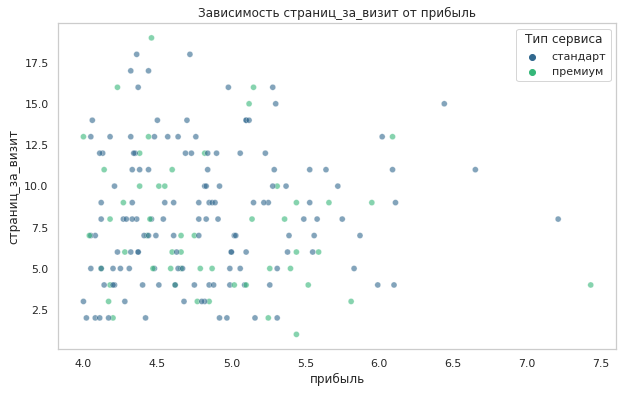

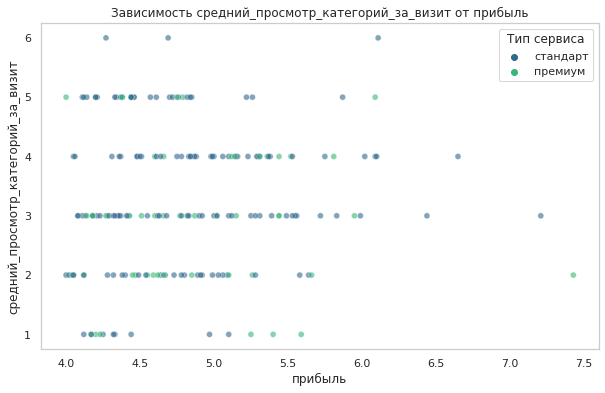

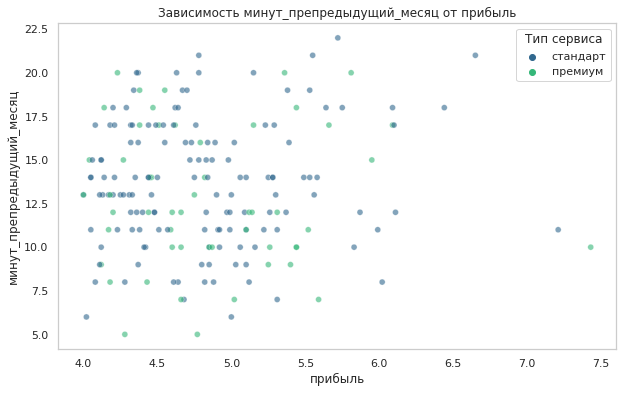

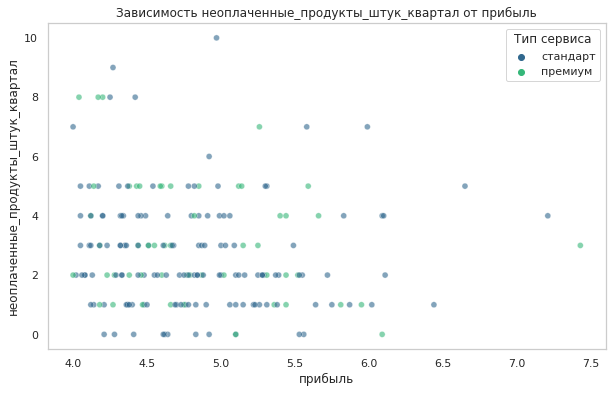

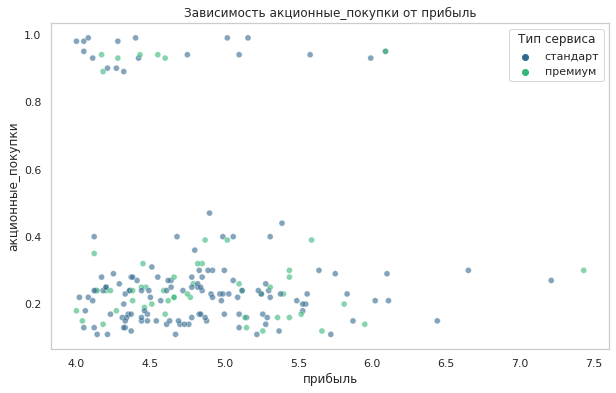

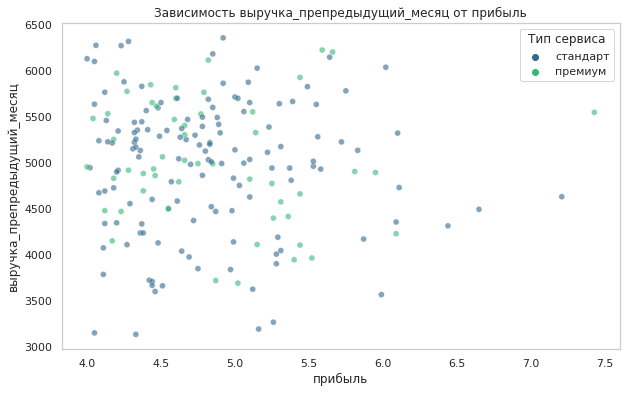

In [67]:
scatplt(unstable_hight, 'прибыль', 'страниц_за_визит')
scatplt(unstable_hight, 'прибыль', 'средний_просмотр_категорий_за_визит')
scatplt(unstable_hight, 'прибыль', 'минут_препредыдущий_месяц')
scatplt(unstable_hight, 'прибыль', 'неоплаченные_продукты_штук_квартал')
scatplt(unstable_hight, 'прибыль', 'акционные_покупки')
scatplt(unstable_hight, 'прибыль', 'выручка_препредыдущий_месяц')

In [68]:

print("Среднее кол-во страниц за визит у клиентов с высокой вероятностью снижения покупательской активности:", round(unstable_hight['страниц_за_визит'].mean(), 2))
print("Среднее кол-во страниц за визит у клиентов с низкой вероятностью снижения покупательской активности:", round(stable_hight['страниц_за_визит'].mean(), 2))
print("Среднее кол-во категорий за визит у клиентов с высокой вероятностью снижения покупательской активности:", round(unstable_hight['средний_просмотр_категорий_за_визит'].mean(), 2))
print("Среднее кол-во категорий за визит у клиентов с низкой вероятностью снижения покупательской активности:", round(stable_hight['средний_просмотр_категорий_за_визит'].mean(), 2))
print("Среднее кол-во минут в предыдущем месяце у клиентов с высокой вероятностью снижения покупательской активности:", round(unstable_hight['минут_препредыдущий_месяц'].mean(), 2))
print("Среднее кол-во минут в предыдущем месяце у клиентов с низкой вероятностью снижения покупательской активности:", round(stable_hight['минут_текущий_месяц'].mean(), 2))
print("Среднее кол-во продуктов в корзине у клиентов с высокой вероятностью снижения покупательской активности:", round(unstable_hight['неоплаченные_продукты_штук_квартал'].mean(), 2))
print("Среднее кол-во продуктов в корзине у клиентов с низкой вероятностью снижения покупательской активности:", round(stable_hight['неоплаченные_продукты_штук_квартал'].mean(), 2))
print("Среднее кол-во доли акционных товаров у клиентов с высокой вероятностью снижения покупательской активности:", round(unstable_hight['акционные_покупки'].mean(), 2))
print("Среднее кол-во доли акционных товаров у клиентов с низкой вероятностью снижения покупательской активности:", round(stable_hight['акционные_покупки'].mean(), 2))

Среднее кол-во страниц за визит у клиентов с высокой вероятностью снижения покупательской активности: 8.09
Среднее кол-во страниц за визит у клиентов с низкой вероятностью снижения покупательской активности: 8.11
Среднее кол-во категорий за визит у клиентов с высокой вероятностью снижения покупательской активности: 3.26
Среднее кол-во категорий за визит у клиентов с низкой вероятностью снижения покупательской активности: 3.18
Среднее кол-во минут в предыдущем месяце у клиентов с высокой вероятностью снижения покупательской активности: 13.43
Среднее кол-во минут в предыдущем месяце у клиентов с низкой вероятностью снижения покупательской активности: 13.26
Среднее кол-во продуктов в корзине у клиентов с высокой вероятностью снижения покупательской активности: 2.81
Среднее кол-во продуктов в корзине у клиентов с низкой вероятностью снижения покупательской активности: 2.82
Среднее кол-во доли акционных товаров у клиентов с высокой вероятностью снижения покупательской активности: 0.32
Средн

In [69]:
data['сегментация'] = data.apply( lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.65 and row['прибыль'] > 4 \
        else 'Остальные пользователи', axis=1)

Глянем на коммуникации с клиентом:

In [70]:
def chart_hist_(data, x, hue):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=x, hue=hue, multiple="stack", palette="pastel", bins=30, alpha=0.7)
    plt.title(f'Распределение {x} по сегментации')
    plt.xlabel(x)
    plt.ylabel('Количество')
    plt.grid()
    plt.legend(title=hue)
    plt.show()

No handles with labels found to put in legend.


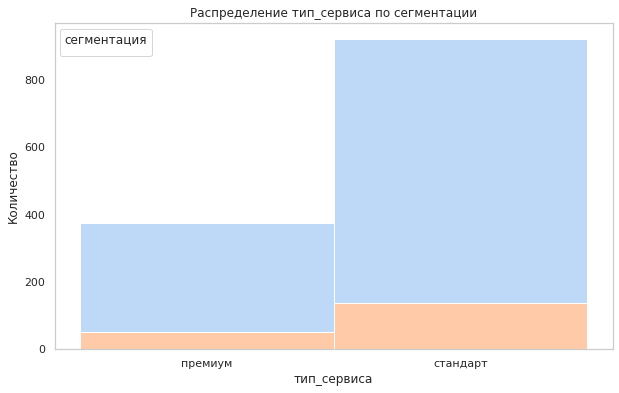

No handles with labels found to put in legend.


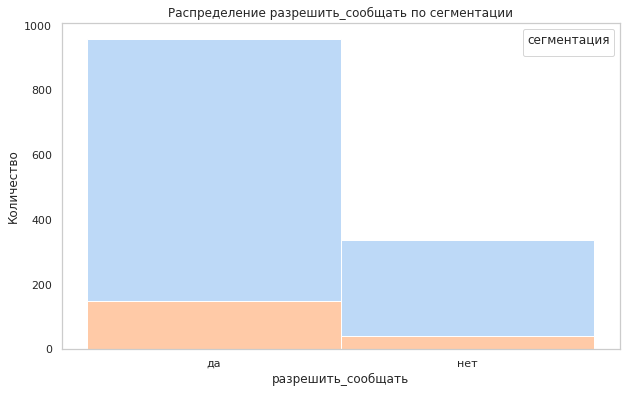

No handles with labels found to put in legend.


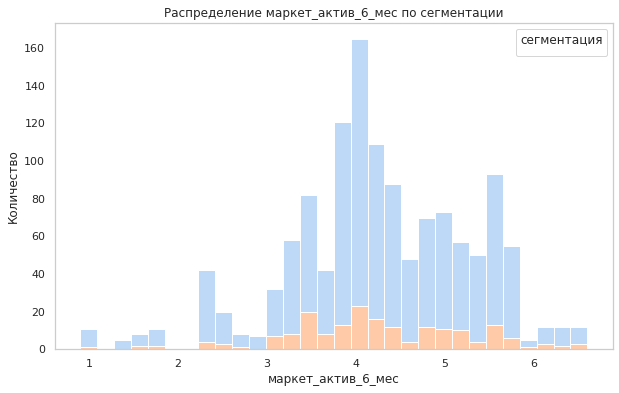

No handles with labels found to put in legend.


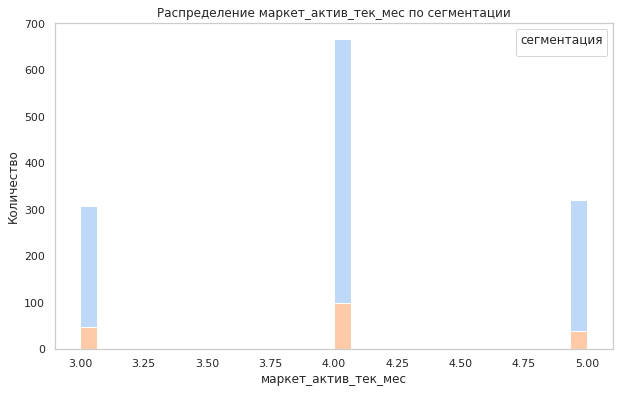

No handles with labels found to put in legend.


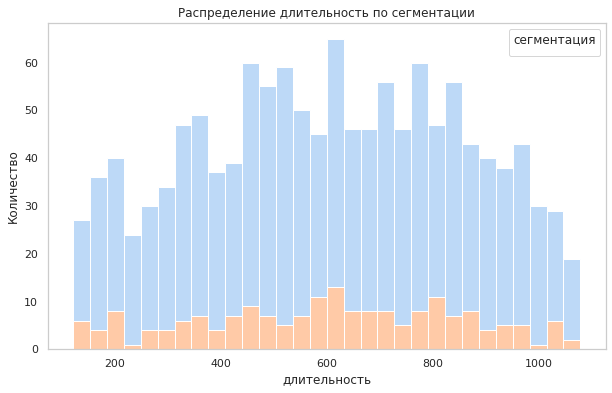

In [71]:
chart_hist_(data, 'тип_сервиса', 'сегментация')
chart_hist_(data, 'разрешить_сообщать', 'сегментация')
chart_hist_(data, 'маркет_актив_6_мес', 'сегментация')
chart_hist_(data, 'маркет_актив_тек_мес', 'сегментация')
chart_hist_(data, 'длительность', 'сегментация')

На данных графиках видим, что выделенный сегмент клиентов, который является целевой аудиторией и с высокой долей вероятности снизит свои траты в маркетплейсе практически отличается от остальной массы клиентов маркетинговой активностью, а также разрешением предоставлять такую активность в принципе.

Посмотрим на продуктовое поведение клиентов и чем оно отличается.

No handles with labels found to put in legend.


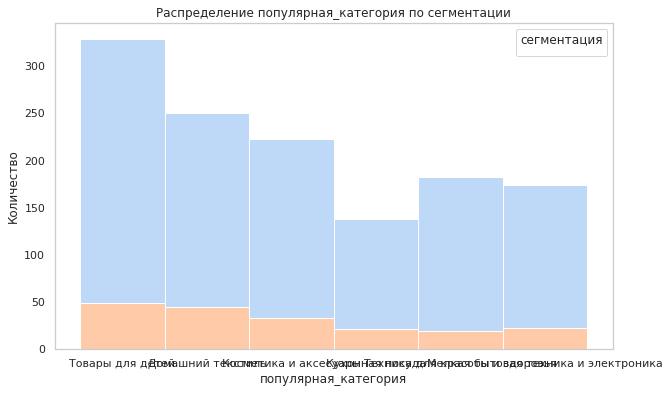

No handles with labels found to put in legend.


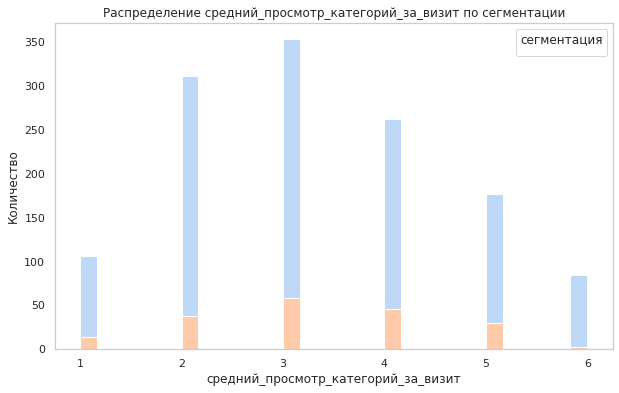

No handles with labels found to put in legend.


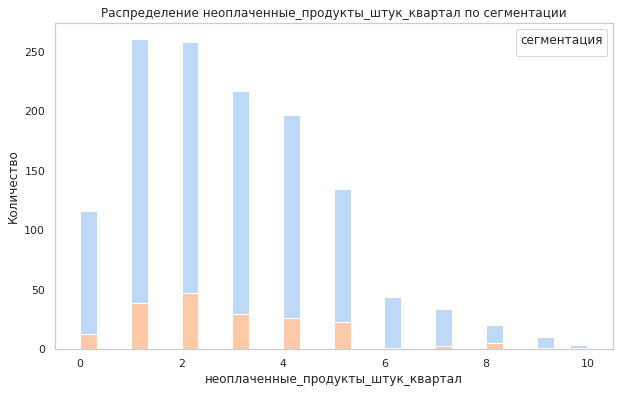

In [72]:
chart_hist_(data, 'популярная_категория', 'сегментация')
chart_hist_(data, 'средний_просмотр_категорий_за_визит', 'сегментация')
chart_hist_(data, 'неоплаченные_продукты_штук_квартал', 'сегментация')

Косметика и акссесуары, а также товары для детей наиболее предпочитетльные категории для исследуемой группы. Поведение по просмотренным категориям так же не очень сильно отличается. На что стоит обратить тут внимание это что кол-во товаров в коризне у них сильно меньше. Они не добавляют товар в коризну и поэтому не так сильно задаются целью купить его со следующей зарплаты.

Глянем на поведение клиентов на сайте.

No handles with labels found to put in legend.


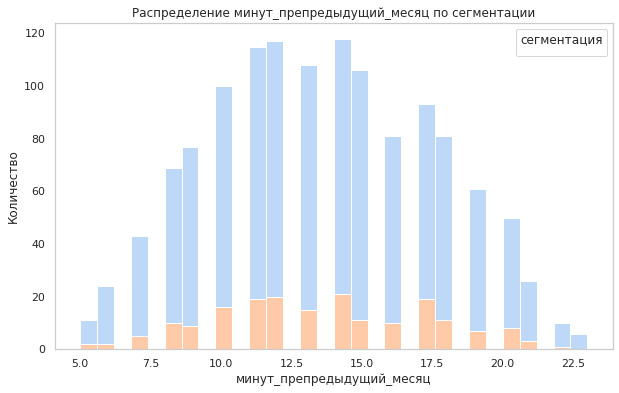

No handles with labels found to put in legend.


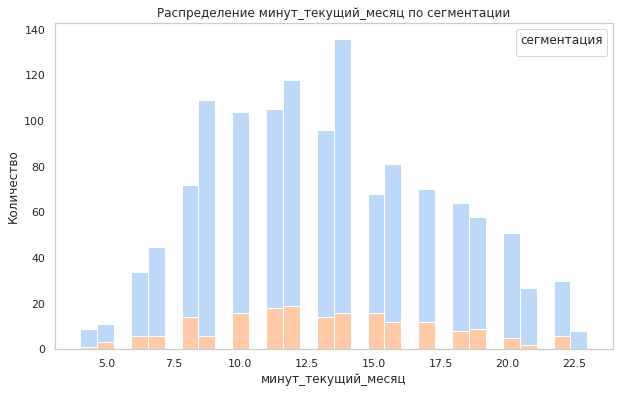

No handles with labels found to put in legend.


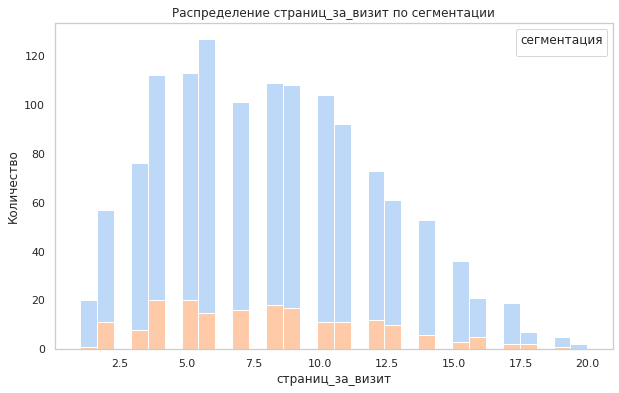

No handles with labels found to put in legend.


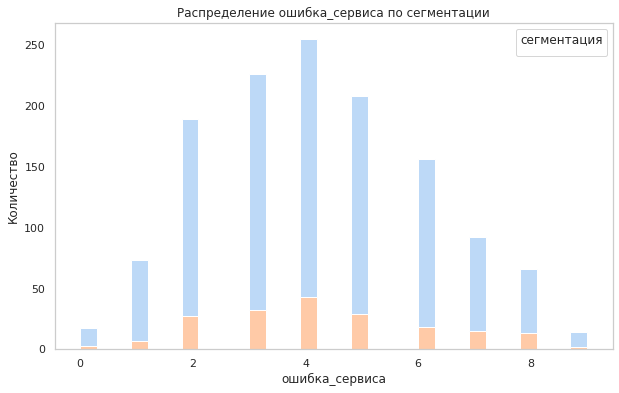

In [73]:
chart_hist_(data, 'минут_препредыдущий_месяц', 'сегментация')
chart_hist_(data, 'минут_текущий_месяц', 'сегментация')
chart_hist_(data, 'страниц_за_визит', 'сегментация')
chart_hist_(data, 'ошибка_сервиса', 'сегментация')

По поведению на сайте так же нет каки-либо сильно выбиывающихся наблюдений за исключением того, что они посещают мало страниц за визит

Глянем на финансовое поведение исследуемой группы:

No handles with labels found to put in legend.


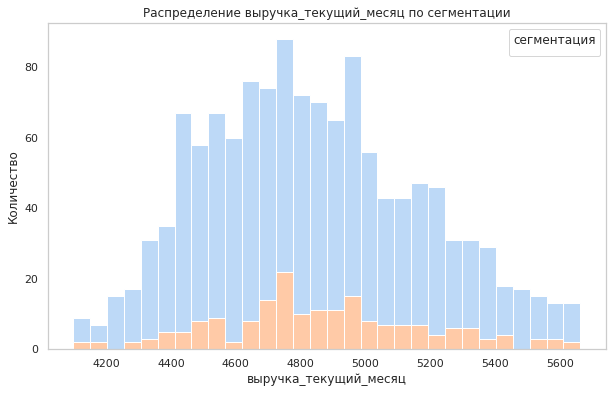

No handles with labels found to put in legend.


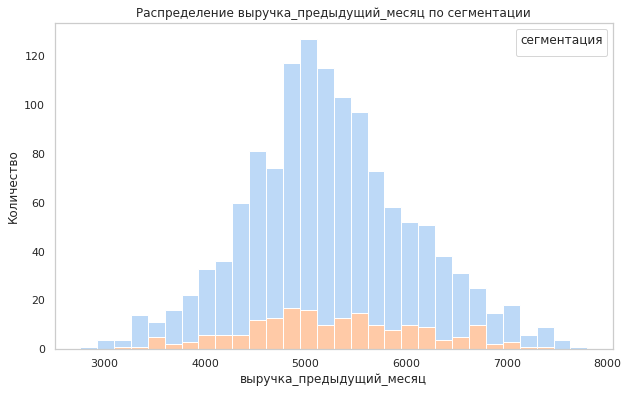

No handles with labels found to put in legend.


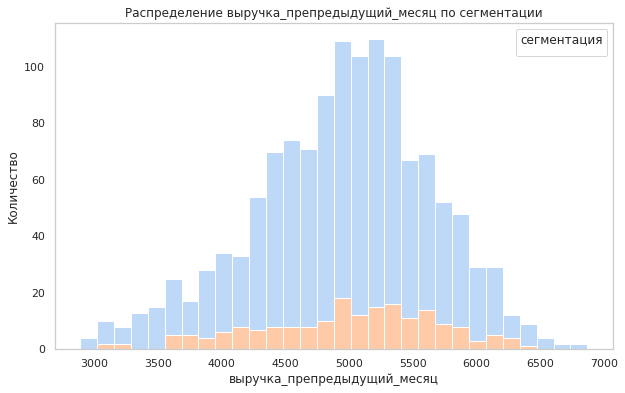

In [74]:
chart_hist_(data, 'выручка_текущий_месяц', 'сегментация')
chart_hist_(data, 'выручка_предыдущий_месяц', 'сегментация')
chart_hist_(data, 'выручка_препредыдущий_месяц', 'сегментация')

## Выводы по сегментации клиентов

Сегментация клиентов была проведена на основе двух ключевых критериев: вероятности снижения покупательской активности и прибыльности. В результате выделились четыре группы клиентов, из которых наиболее важно изучить ту, которая приносит высокий доход, но при этом имеет высокую вероятность снижения покупательской активности.

### Сравнение групп

Сравнение клиентов с высокой прибыльностью и высокой вероятностью снижения активности с клиентами, имеющими аналогичную прибыль, но низкую вероятность снижения активности, показало, что проблема заключается во всех признаках, которые модель определила как наиболее важные. 

Мы наблюдаем, что для достижения аналогичного уровня вовлеченности клиентов необходимо увеличить количество страниц, которые они просматривают. Это логично: чем больше страниц пролистано, тем выше вероятность найти что-то интересное. Аналогичная логика применима к следующим метрикам:
- Количество просмотренных категорий
- Количество неоплаченных продуктов в корзине
- Время, проведенное на маркетплейсе
- Количество акционных товаров

Однако стоит отметить, что все эти признаки сами по себе имеют незначительные различия в значениях, но в совокупности они дают неутешительный прогноз.



# Общий вывод проекта: Анализ покупательской активности

В ходе выполнения проекта по анализу покупательской активности клиентов были достигнуты следующие ключевые результаты и выводы:

## 1. Цель и задачи проекта
Основной целью исследования было создание модели машинного обучения для предсказания снижения покупательской активности клиентов на основе их поведения на сайте и финансовых показателей. В процессе работы были выполнены задачи по предобработке данных, исследовательскому анализу, моделированию и сегментации клиентов.

## 2. Анализ данных
- Проведен детальный анализ структуры и характеристик данных, что позволило выявить наличие пропусков и аномалий. Все данные были очищены и подготовлены для дальнейшего анализа.
- Исследовательский анализ данных (EDA) показал, что некоторые количественные признаки имеют нормальное распределение, в то время как другие — бимодальное или скошенное. Это указывает на необходимость дальнейшего изучения и возможной трансформации данных.

## 3. Моделирование
- Были протестированы различные модели классификации, включая KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC. Наилучшие результаты показала модель SVC с ROC AUC 0.914, что свидетельствует о высокой точности предсказаний.
- Важность признаков была оценена с использованием метода SHAP, что позволило выявить ключевые факторы, влияющие на покупательскую активность, такие как количество страниц за визит, время, проведенное на сайте, и количество акционных покупок.

## 4. Сегментация клиентов
- На основе вероятности снижения активности и прибыльности клиентов была проведена сегментация, что позволило выделить группы с различными уровнями риска. Это поможет бизнесу сосредоточить усилия на наиболее уязвимых сегментах, которые могут снизить свою активность.
- Выявлено, что клиенты с высокой вероятностью снижения активности имеют схожие характеристики, такие как низкое количество просмотренных страниц и категорий, что указывает на необходимость улучшения взаимодействия с этими клиентами.



## 5. Заключение
- Результаты исследования предоставляют бизнесу ценные инсайты для оптимизации маркетинговых стратегий и повышения общей выручки. Созданная модель может быть использована для прогнозирования активности клиентов на новых данных, что позволит более эффективно планировать маркетинговые усилия и улучшать взаимодействие с клиентами.

В целом, проект продемонстрировал значимость анализа покупательской активности и его влияние на бизнес-стратегии, что может привести к улучшению финансовых показателей и повышению удовлетворенности клиентов.